# SSMachine Tutorial

In [1]:
import glob
import numpy as np
import pandas as pd
import lightkurve as lk
import psfmachine as pm
from astropy.io import fits
from scipy import sparse

import matplotlib.pyplot as plt

import warnings
from astropy.utils.exceptions import AstropyUserWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)
warnings.filterwarnings("ignore", category=AstropyUserWarning)

## K2 Super Stamps Tutorial

This notebook shows how to use `PSFMachine` and the submodule `SSMachine` to work with K2 Super Stamps images produced by 
[Cody et al. 2018](https://archive.stsci.edu/prepds/k2superstamp/).
[`PSFMachine`](https://github.com/SSDataLab/psfmachine) uses Gaia as source catalog and fits a PSF model of the "scene" (all sources) at once.
The method is described with details in [Hedges et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....162..107H/abstract).

K2 Super stamps are stored in single FITS files per cadence that are parsed by `SSMAchine` to then use the `Mahine` class.
This object class has several handy methods that allow us to get a scene PSF model and fit it to get PSF photometry, as well as aperture photometry
with aperture masks that follows the PSF profile. `Machine` also provides several plotting functionalities to create diagnostic figures and for
bookkeeping.
For more details on how to use `PSFMachine`, please take a look at this [notebook tutorial](https://github.com/SSDataLab/psfmachine/blob/master/tutorials/how_to_use_TPFMachine.ipynb) 
and its [documentation](https://ssdatalab.github.io/psfmachine/).

In this example we'll work with M67.

## M67 open clusters

First, make sure you have the data stored locally. [Here](https://archive.stsci.edu/prepds/k2superstamp/)
are instructions on how to download it.

In [2]:
# modify this to refelt the directory path on your system
data_path = "/Users/jorgemarpa/Work/BAERI/ADAP/data/k2/superstamps/m67"
m67_fnames = np.sort(glob.glob(
    f"{data_path}/hlsp_k2superstamp_k2_photometer_c5-m67-*_kepler_v1_image.fits"))

Each FITS file contains a single cadence (epoch), here's and example of the file content

In [3]:
m67_hdu = fits.open(m67_fnames[1])
m67_hdu.info()

Filename: /Users/jorgemarpa/Work/BAERI/ADAP/data/k2/superstamps/m67/hlsp_k2superstamp_k2_photometer_c5-m67-bjd2457139.6315_kepler_v1_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     176   (400, 400)   float32   


## Create a `Machine` object

The `SSMachine` module has the static method `SSMachine.from_file` that allows us to load a stack of FITS files.
We just have to provide the path to each FITS file as a list and other parameters such as:

* `magnitude_limit`: the limiting magnitude to query Gaia catalog
* `dr`: which is the Gaia Data Release, if 3 then uses EDR3
* `surces`: a Pandas DataFrame with the source catalog. This will avoid querying Gaia.
* Other `**kwargs` that define model parameters in `Machine`, see [here](https://ssdatalab.github.io/psfmachine/machine/#psfmachine.machine.Machine.__init__) for details.

Internally, `Machine` queries Gaia catalogs to fins sources on and nearby pixels.
In this case we limit the Gaia EDR3 query to sources up to 18th magnitude. Also, we'll only load the first 500 cadences for this example.
If we `print` the object will return a brief description of the available data.

In [5]:
m67 = pm.SSMachine.from_file(m67_fnames[:500].tolist(), magnitude_limit=18, dr=3)

# if we have the source catalog save in a local file "m67_leq18_catalog.hdf" 
# we can speed up the initialization by skiping the gaia query
# m67 = pm.SSMachine.from_file(m67_fnames[:500].tolist(), magnitude_limit=18, dr=3,
#                              sources=pd.read_hdf("m67_leq18_catalog.hdf", "table"))

m67

Creating delta arrays: 100%|██████████| 1019/1019 [00:01<00:00, 602.20it/s]


FFIMachine (N sources, N times, N pixels): (1019, 500, 156578)

In [6]:
# the `m67.meta` attribuite has general information of the data
m67.meta

{'TELESCOP': 'Kepler',
 'INSTRUME': 'Kepler Photometer',
 'MISSION': 'K2',
 'OBSMODE': 'long cadence',
 'OBJECT': 'M67',
 'RADESYS': 'ICRS',
 'EQUINOX': 2000.0,
 'BACKAPP': True,
 'EXTENSION': None,
 'QUARTER': 5,
 'DCT_TYPE': 'SuperStamp'}

Let's see how **M67** looks like as seen with Kepler eyes! The red circles are Gaia EDR3 sources.

There are some nasty crosstalk artifacts

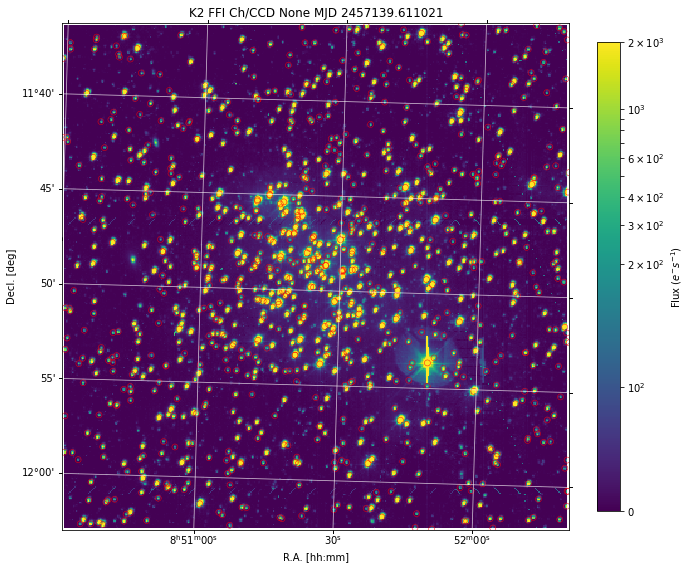

In [7]:
m67.plot_image(sources=True);

## PSF model
### mean-PSF

Now let's build a PSF model (aka shape model). For this, `SSMachine` (inherited from `Machine`) has the `.build_shape_model()` method.
Here, `.build_shape_model()` accepts the parameter `cadenceno` that can be an integer (cadence number) or `mean` to use the time-averaged flux. 
If `frame_index` is an int, the it uses the flux of that particular cadence to fit the PRF, if is `mean` the computes a PSF model of the mean flux.

The figure shows the PSF model in both Cartesian (left) and Polar (right) coordinates, and the data (top) and model (bottom).

This **mean PRF** model looks pretty neat!

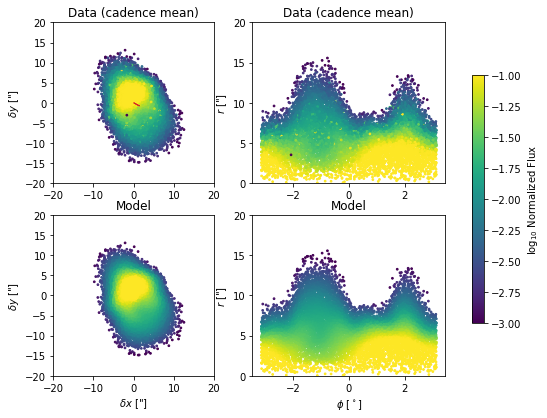

In [8]:
m67.build_shape_model(frame_index='mean', plot=True);

### PSF at every cadence

But we know that K2 suffer from strong spacecraft motion noise that reflect in a constant jump of the source centroids (in CCD pixel space).
This effect can not be seen in the `mean` PSF flux. But if we fit a shape model at each cadence, we'll see the effect.

`SSMachine` includes a method that allows to build a PSF model for every cadence. This somehow possible here because Super Stamps have enough sources, 
and therefore number of pixels, to fit a smooth model. In this case > 1k sources and > 155k pixels with flux data (not background).
Also, `SSMachine` will create a movie of the shape models, just for fun! (you can disable this setting `plot=False`)

This step will take time! We are fitting a PSF model at each cadence (here only 500 as example). Under the hood its solving a linear problem
with matrices that are `[n_sources x n_pixels] = [1k x 155k]` 500 times, with some neat computational and mathematical tricks though.
It'll take ~15 min to do 500 cadences.

In [9]:
m67.build_frame_shape_model(plot=True)

Building shape model per frame: 100%|███████████████████████████████████████████████| 500/500 [14:56<00:00,  1.79s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (684, 468) to (688, 480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fd92e040000] Warning: data is not aligned! This can lead to a speed loss


<video autoplay loop controls src="shape_models_K2_M67_c5.mp4" />

Our PSF model is nice and smooth but it constantly shifting position!

## Get PSF photometry
### PSF at every cadence

Now we'll use the PSF model to fit the flux of every source simultaneously at every cadence.
Let's use the PSFs we build at each cadence with `.fit_frame_models()`.

In [10]:
m67.fit_frame_model()

Fitting 1001 Sources (per frame model): 100%|███████████████████████████████████████| 500/500 [00:48<00:00, 10.31it/s]


### mean-PSF

For comparison, as explained in the paper, `Machine` uses a **time polynomial** to fit the smooth drift in position (velocity aberration) of all sources (the scene).
This is a nice solution when the drift is fairly smooth, the case of Kepler, but for K2 the dominant factor is the jitter we saw above.
Still, let's try to fit this "time model" and compare results. For more info on how `.built_time_model()` works see the 
paper, [documentation](https://ssdatalab.github.io/psfmachine/machine/#psfmachine.machine.Machine.build_time_modelx), or the more
extended *Tutorial_31_k2ss*.

The following plot shows the pixel's flux (normalized with the time-averaged flux) data (top) that are used to build the PSF model 
(bottom) at the first (left) and last (right) cadence. As sources drifts across the sensor the normalized flux at each pixel 
changes from <1 to >1 values.

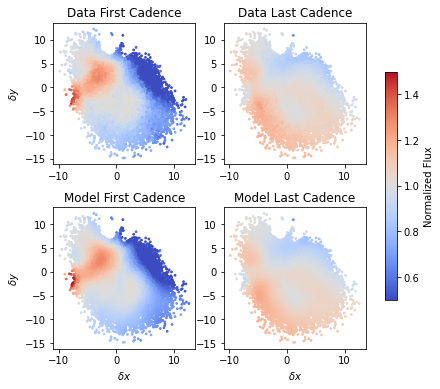

In [9]:
# we need to run .build_shape_model(cadenceno='mean') again to have the
# right source masks inside machine,
m67.time_corrector = "polynomial"
m67.build_shape_model(frame_index='mean', plot=False);
m67.build_time_model(plot=True);

To get the flux at each time, we use the `.fit_model()` method that computes PSF photometry using the mean PSF model, using the `fit_va=True` flag
it turns on the "time model" described above.

In [11]:
m67.fit_model(fit_va=True)

Fitting 1019 Sources (w. VA): 100%|██████████| 500/500 [00:57<00:00,  8.75it/s]


### Aperture Photometry

`Machine` also includes the option to compute SAP fluxes. To create the aperture masks we use the PSF shape (in this case the mean-PSF model) to define
isophotes and the aperture borders.
To get SAP light curves we use `.compute_aperture_photometry(aperture_size="optimal", target_complete=1, target_crowd=1)`,
for details in the parameters see [here](https://ssdatalab.github.io/psfmachine/machine/#psfmachine.machine.Machine.compute_aperture_photometry).
In short, the aperture size is optimized to maximize the enclosed flux (`target_complete`) and minimize the contamination (`target_crowd`) of the source.

In [12]:
m67.compute_aperture_photometry(
                aperture_size="optimal", target_complete=1, target_crowd=1
            )

SAP: 100%|██████████| 1019/1019 [00:00<00:00, 1102.84it/s]


## Let's create some light curves

Now that we have fitted our PSF models we have new attributes that have the time series for each case:

* `ws` and `werrs` have the uncorrected PSF flux and flux errors.
* `ws_va` and `werrs_va` have the PSF flux and flux errors corrected with the time model, aka velocity aberration.
* `ws_frame` and `werrs_frame` have the flux from PSF at each cadence.
* `sap_flux` and `sap_flux_err` have the flux and flux errors computed using aperture mask.

Also, `self.time` has the time array.

Let's plot some light curves

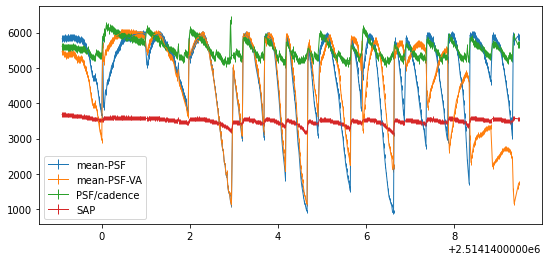

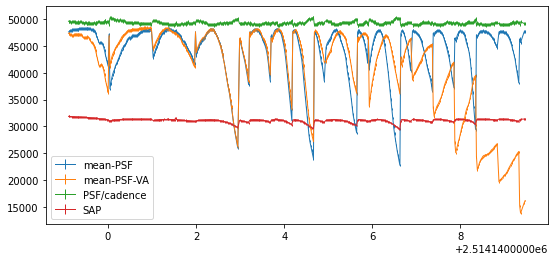

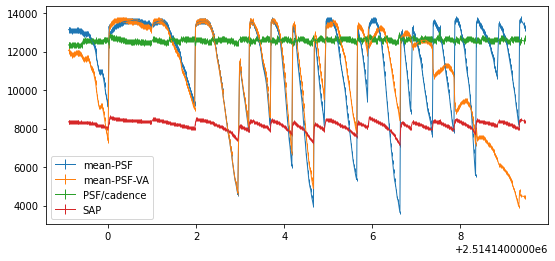

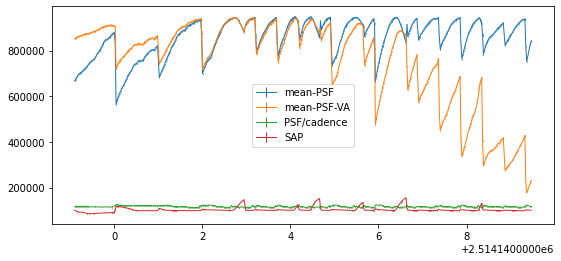

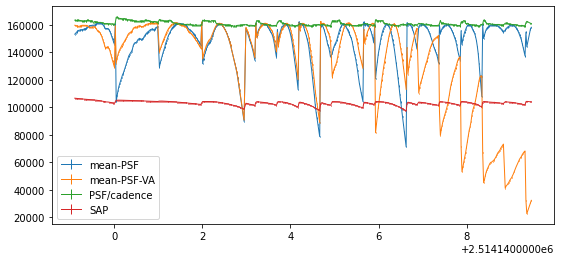

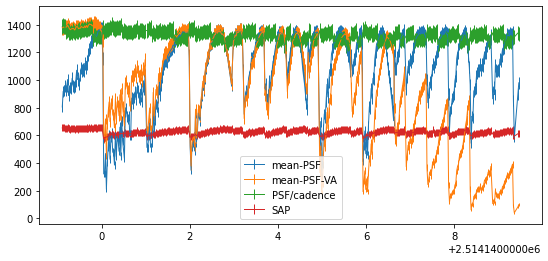

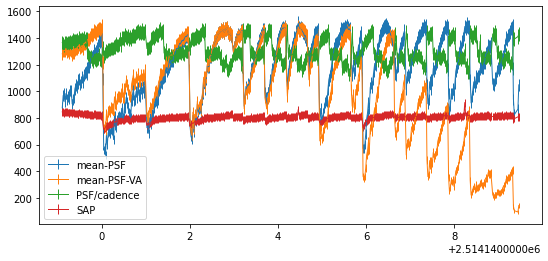

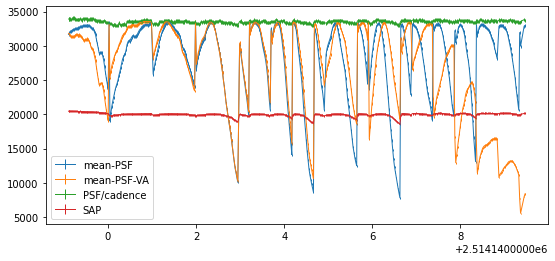

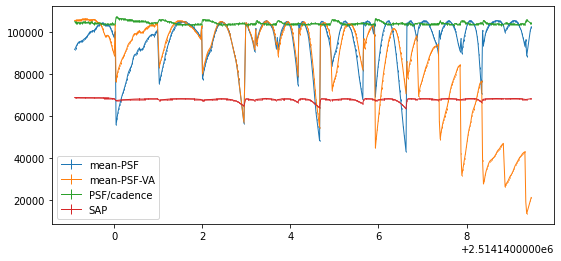

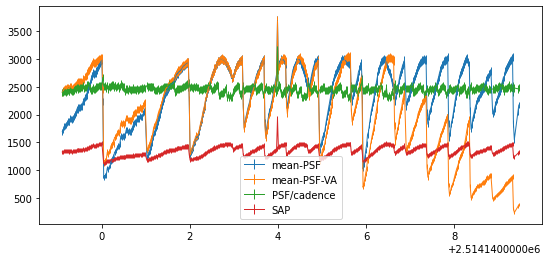

In [30]:
for k in range(0, 1000, 100):
    fig, ax = plt.subplots(1, 1, figsize=(9,4))
    ax.errorbar(m67.time, m67.ws[:, k], yerr=m67.werrs[:, k], label="mean-PSF", lw=1, color="tab:blue")
    ax.errorbar(m67.time, m67.ws_va[:, k], yerr=m67.werrs_va[:, k], label="mean-PSF-VA", lw=1, color="tab:orange")
    ax.errorbar(m67.time, m67.ws_frame[:, k], yerr=m67.werrs_frame[:, k], label="PSF/cadence", lw=1, color="tab:green")
    ax.errorbar(m67.time, m67.sap_flux[:, k], yerr=m67.sap_flux_err[:, k], label="SAP", lw=1, color="tab:red")
    plt.legend(loc="best")
    plt.show()

We see how the light curves with just the mean-PSF model (blue) have variability patterns due to the spacecraft jitter. The mean-PSF-VA model (orange)
that uses a smooth time polynomial to fit the position drift removes just a small fraction of the variability patter but introduces a long term trend 
(decaying tail at the end of the series). the PSF model per cadence (green) tries to remove the jitter noise but not fully, also it sometimes introduces 
high frequency noise due to the slightly less robust PSF models compared to the mean-PSF.

## All in one command

You can also do all the previous steps in just one command, `self.fit_lightcurves()` will do each steps in order to get 
a list of nice `lightkurve.KeplerLightCurves` objects. 
Each element will contain all the types of photometry we described above as columns

In [21]:
m67.fit_lightcurves(plot=False,
                    iter_negative=True,
                    fit_mean_shape_model=True,
                    fit_va=True,
                    sap=True)

Fitting 1001 Sources (per frame model): 100%|███████████████████████████████████████| 500/500 [00:38<00:00, 12.93it/s]


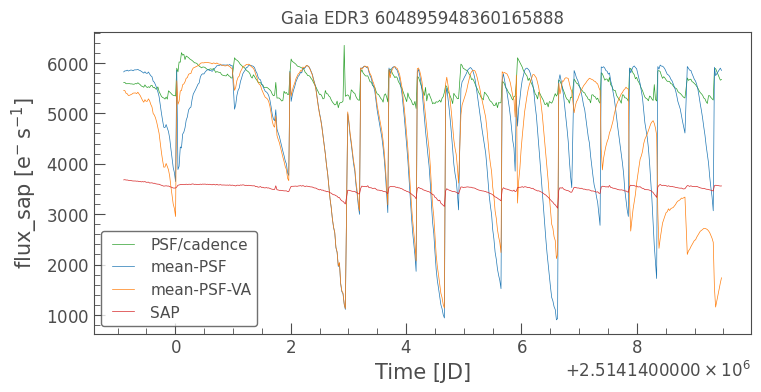

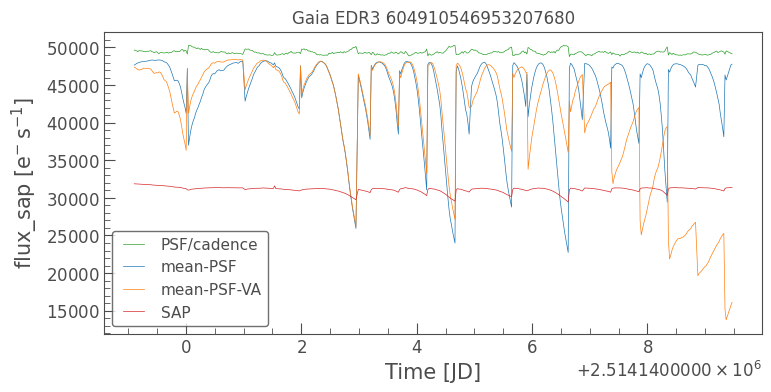

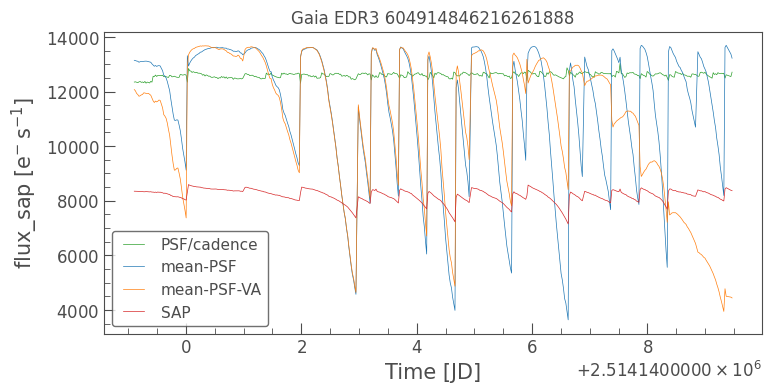

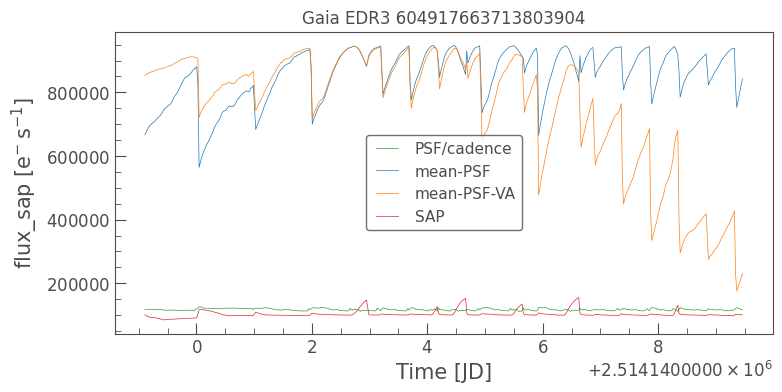

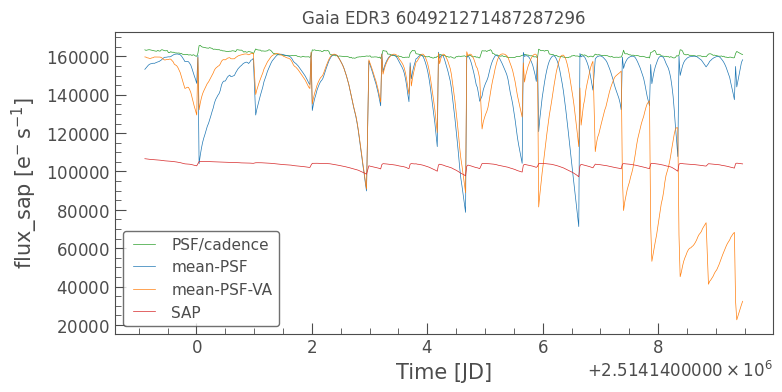

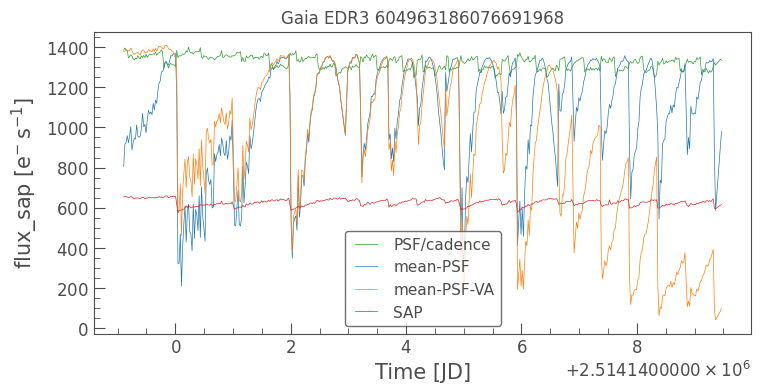

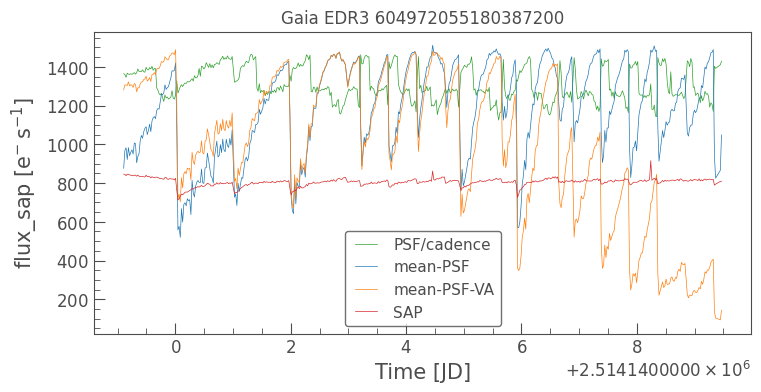

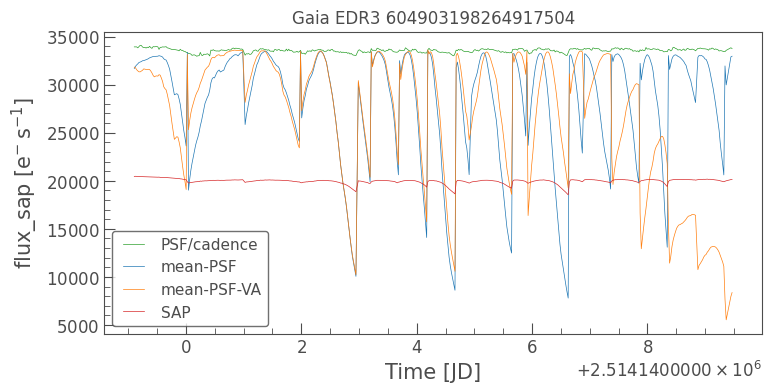

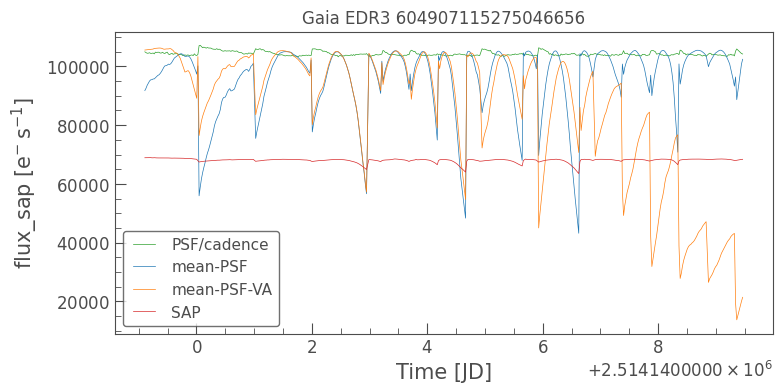

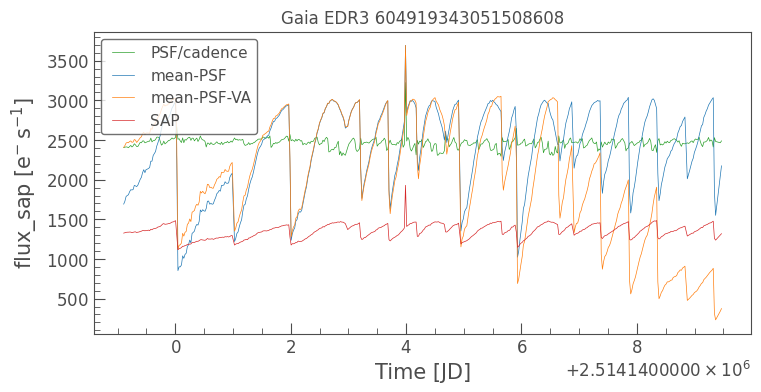

In [31]:
for lc in m67.lcs[0:1000:100]:
    ax = lc.plot(label="PSF/cadence", color="tab:green")
    ax.set_title(lc.label)
    lc.plot(column="flux_NVA", label="mean-PSF", color="tab:blue", ax=ax)
    lc.plot(column="flux_VA", label="mean-PSF-VA", color="tab:orange", ax=ax)
    lc.plot(column="flux_sap", label="SAP", color="tab:red", ax=ax)
    plt.show()